# Utils

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from glob import glob
import numpy as np

In [ ]:
# this is a simplified version of what is used in the detection workflow that doesn't rely on pytorch
class KITTIDataset():
    
    def __init__(self, img_dir, label_dir, label_map, transforms=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.img_paths = glob(os.path.join(img_dir, "*.jpg"))  
        self.label_map = label_map        
                
    def parse_kitti(self, path):
        # https://github.com/NVIDIA/DIGITS/blob/v4.0.0-rc.3/digits/extensions/data/objectDetection/README.md
        objects = []
        with open(path, 'r') as f:
            for line in [l.strip() for l in f.readlines()]:
                label, _, _, _, xmin, ymin, xmax, ymax, *_ = line.split()
                objects.append({'label': label, 'bounds': [float(x) for x in [xmin, ymin, xmax, ymax]]})            
        return objects            
            
    def __getitem__(self, idx):
        
        # load images and bounding boxes        
        img_path = self.img_paths[idx]
        img_id, _ = os.path.splitext(os.path.basename(img_path))        
        label_path = os.path.join(self.label_dir, img_id + ".txt")
                
        img = Image.open(img_path).convert("RGB")
        objects = self.parse_kitti(label_path)                
        boxes = np.array([o['bounds'] for o in objects], dtype=np.float32)
        labels = np.array([self.label_map[o['label'].lower()] for o in objects], dtype=np.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = np.array([idx])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        target["iscrowd"] = np.zeros((len(objects),), dtype=np.int64)
        target["filename"] = img_path
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
    
    def __len__(self):
        return len(self.img_paths)

In [ ]:
def display_annotation(image, target, label_map, prediction=None, thresh=0, size=None):
    
    # invert labelmap
    label_map = {v:k for k,v in label_map.items()}
    
    label_offset_x = 0
    label_offset_y = -2
    fig, ax = plt.subplots(figsize=size)       
    
    ax.imshow(image) # assumes image is a torch.tensor
    
    # ground truth
    boxes = target['boxes']    
    for i in range(boxes.shape[0]):
        x1, y1, x2, y2 = target['boxes'][i]
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')    
        ax.add_patch(rect)
        ax.text(x1 + label_offset_x, y1 + label_offset_y, f"{label_map[target['labels'][i].item()]}", color='r')
        ax.set_title(target["filename"])
        
    # prediction
    if prediction:
        boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
        for i in range(boxes.shape[0]):            
            if scores[i] > thresh:
                x1, y1, x2, y2 = boxes[i]
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='g', facecolor='none')    
                ax.add_patch(rect)  
                text = f"{label_map[labels[i].item()]} {scores[i]:.2f}"
                ax.text(x1 + label_offset_x, y2 - 6*label_offset_y, text, color='g')
    plt.show()        

# Workflow

In [ ]:
data_dir = "data"
image_dir = os.path.join(data_dir, "Core_Images_KITTI")
label_dir = os.path.join(data_dir, "Core_Annotations_KITTI")

if not os.path.exists(image_dir):
    print(f"image directory {image_dir} doesn't exist")
if not os.path.exists(label_dir):
    print(f"image directory {image_dir} doesn't exist")    

# need a default background class
label_map = {
    'background': 0,
    'core': 1,
    'flake': 2,
    'flake_broken': 3,
    'tool': 4
}

# define datasets
ds = KITTIDataset(image_dir, label_dir, label_map)
print(f"dataset has {len(ds)} images")

### Data Review

In [ ]:
# check example
image, target = ds[0]
display_annotation(image, target, label_map, size=(10, 10))

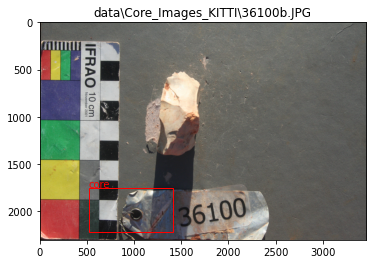

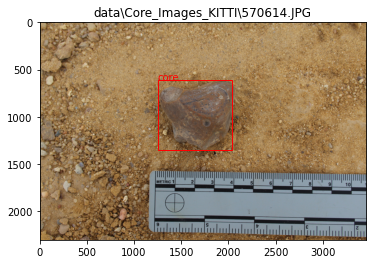

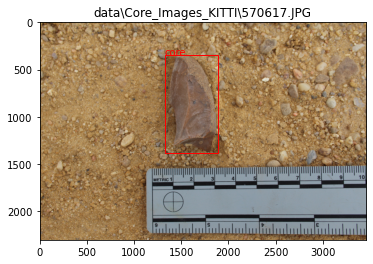

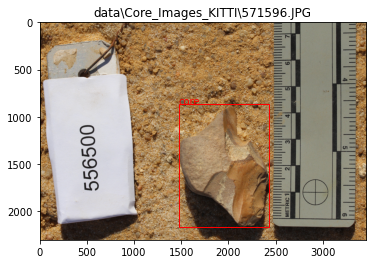

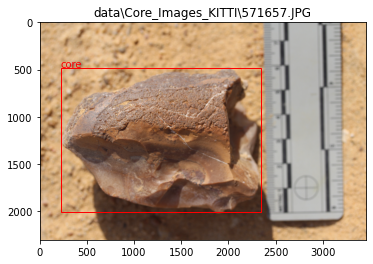

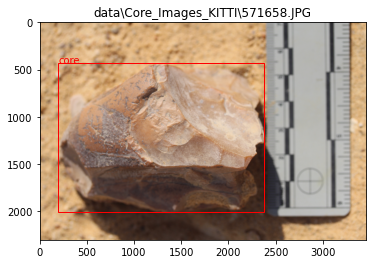

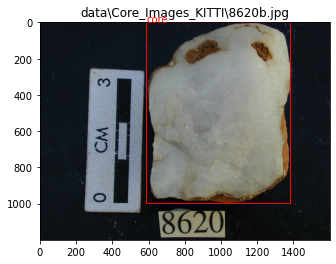

In [14]:
# check all images
for i in range(len(ds.img_paths)):
    image, target = ds[i]
    display_annotation(image, target, label_map)